In [3]:
import csv
import pandas as pd
import numpy as np
import collections

import xgboost as xgb
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.figure
%matplotlib inline

from numpy import sort

from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, classification_report, roc_curve, auc, \
accuracy_score,f1_score, confusion_matrix, precision_recall_curve, roc_auc_score

pd.set_option('display.max_columns', None)

## Preprocessing

In [4]:
df = pd.read_csv('2020-train.csv')
df.head(5)

,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,balls,strikes,release_speed,vert_release_angle,horz_release_angle,spin_rate,spin_axis,tilt,rel_height,rel_side,extension,vert_break,induced_vert_break,horz_break,plate_height,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,pitch_type,pitch_call,pitch_id
0,d7e3acce,Right,32678d8d,Right,a4833794,f88d09f4,83cdf9ff,3,1,0.0,0,1,93.008102,-1.990750,-0.364950,1995.780029,-150.653000,1:00,5.97789,0.221744,6.45304,-12.477000,18.268900,9.38941,3.05034,0.555689,86.024200,-4.37258,1.429580,0.404622,-0.059343,55,6.03322,FA,InPlay,42fce2f6
1,44ec1bf5,Right,81d51733,Left,f60d6ea5,b67d862c,a126f66f,6,2,0.0,3,2,97.935898,-2.916730,-2.695220,2388.689941,-170.166000,12:15,6.18328,2.123090,6.37298,-10.453700,18.147200,2.89933,2.61284,-0.111897,89.458199,-4.90467,-2.148410,0.385719,-2.148680,55,6.23380,FA,InPlay,3e9cda86
2,44d87ee6,Left,8eefccb7,Right,a9b8b538,13993d26,9db4e46f,5,2,2.0,3,1,81.831398,-1.576020,1.045500,1966.949951,159.830994,11:15,6.12413,-1.294740,6.13114,-23.592199,17.337099,-6.18609,2.63461,-0.937995,75.593597,-6.00728,-0.122044,0.463953,1.300450,55,6.14750,CH,BallCalled,f129a6cd
3,ff6adae0,Right,8f8ab5af,Right,e569ec39,0d8ba4bb,bbbfd290,5,1,2.0,1,2,83.775703,-0.387083,-0.613163,2539.459961,54.268398,7:45,6.58357,1.665380,5.59444,-49.169498,-8.342350,-10.58620,2.17409,0.233674,76.396400,-9.50640,-2.581980,0.458471,-1.659590,55,6.60043,CU,InPlay,03e9bc05
4,c70c96e5,Right,10874746,Right,a5ce1bf6,94a4c552,75087ec8,8,1,2.0,2,1,91.208000,0.140618,-4.035290,2409.110107,246.348999,2:15,4.77355,1.495840,6.12665,-24.760099,8.488800,19.89060,2.84640,-0.703636,83.215302,-4.53233,-0.268188,0.415965,-1.526170,55,4.77332,FA,StrikeCalled,48feb675


In [5]:
# 1 = strike, 0 = ball
df['is_strike'] = np.where(df['pitch_call'].isin (['HitByPitch','BallCalled','BallIntentional']), 0 , 1)

In [4]:
df.drop(columns=['pitch_call', 'y55','pitch_id','tilt'], inplace=True)

In [5]:
df.dropna(inplace=True)

In [6]:
572636/582205

0.9835642084832662

## Feature Selection

In [7]:
dfnum = df.loc[:,'outs':'z55']
dfin = df.loc[:,'inning']

In [39]:
dfptb = pd.get_dummies(df['top_bottom'], prefix='top_bottom')
dfptype = pd.get_dummies(df['pitch_type'], prefix='pitch_type')
dfpside = pd.get_dummies(df['pitcher_side'], prefix='pitcher_side')
dfbside = pd.get_dummies(df['batter_side'], prefix='batter_side')
dfptype = pd.get_dummies(df['pitch_type'], prefix='pitch_type')
dfpit = pd.get_dummies(df['pitcher_id'], prefix='pitcher_id')
dfbat = pd.get_dummies(df['batter_id'], prefix='batter_id')
dfcatch = pd.get_dummies(df['catcher_id'], prefix='catcher_id')
dfump = pd.get_dummies(df['umpire_id'], prefix='umpire_id')
dfstad = pd.get_dummies(df['stadium_id'], prefix='stadium_id')

In [41]:
dfm = pd.concat([dfnum, dfin, dfptb, dfptype, dfpside, dfbside, dfptype, dfpit, dfbat, dfcatch, \
                dfump,dfstad], axis=1, sort=False)

In [42]:
X = dfm
y = df['is_strike']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2, random_state=42)

In [44]:
dfm = pd.concat([dfnum, dfin], axis=1, sort=False)

In [45]:
X = dfm
y = df['is_strike']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2, random_state=42)

In [67]:
dfm

,outs,balls,strikes,release_speed,vert_release_angle,horz_release_angle,spin_rate,spin_axis,rel_height,rel_side,extension,vert_break,induced_vert_break,horz_break,plate_height,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,z55,inning
0,0.0,0,1,93.008102,-1.990750,-0.364950,1995.780029,-150.653000,5.97789,0.221744,6.45304,-12.477000,18.268900,9.389410,3.050340,0.555689,86.024200,-4.37258,1.429580,0.404622,-0.059343,6.03322,3
1,0.0,3,2,97.935898,-2.916730,-2.695220,2388.689941,-170.166000,6.18328,2.123090,6.37298,-10.453700,18.147200,2.899330,2.612840,-0.111897,89.458199,-4.90467,-2.148410,0.385719,-2.148680,6.23380,6
2,2.0,3,1,81.831398,-1.576020,1.045500,1966.949951,159.830994,6.12413,-1.294740,6.13114,-23.592199,17.337099,-6.186090,2.634610,-0.937995,75.593597,-6.00728,-0.122044,0.463953,1.300450,6.14750,5
3,2.0,1,2,83.775703,-0.387083,-0.613163,2539.459961,54.268398,6.58357,1.665380,5.59444,-49.169498,-8.342350,-10.586200,2.174090,0.233674,76.396400,-9.50640,-2.581980,0.458471,-1.659590,6.60043,5
4,2.0,2,1,91.208000,0.140618,-4.035290,2409.110107,246.348999,4.77355,1.495840,6.12665,-24.760099,8.488800,19.890600,2.846400,-0.703636,83.215302,-4.53233,-0.268188,0.415965,-1.526170,4.77332,8
5,0.0,2,2,87.095802,-1.765940,-2.663060,1964.719971,264.998993,5.78114,2.075490,5.78314,-34.840801,1.982270,18.361601,1.202610,1.173050,80.265404,-8.24794,0.780148,0.438111,-2.075230,5.79080,7
6,1.0,3,2,97.071701,-2.224720,3.411580,2270.479980,137.667999,6.08352,-2.663860,6.36303,-13.328100,16.047800,-14.320900,2.745180,-0.712306,87.948799,-4.76645,0.696210,0.390590,2.569990,6.09316,3
7,1.0,1,2,82.397301,-2.152430,4.069960,2372.100098,322.580994,6.20321,-2.466780,6.02752,-43.678398,-2.624990,3.282180,0.474190,1.571470,76.352798,-10.25710,4.681720,0.464021,2.497290,6.22659,6
8,1.0,0,0,86.299400,-1.344580,3.599910,1904.939941,154.160004,5.89500,-2.529400,6.35454,-18.394899,18.750099,-8.748260,2.979320,0.024554,78.281097,-4.85101,1.945590,0.440157,2.559950,5.91159,2
9,1.0,3,2,94.156303,-3.388980,-2.308930,2086.100098,224.160004,6.52740,0.886049,5.47456,-14.501100,17.073700,14.586700,2.095660,-0.054626,86.078400,-6.09955,0.425454,0.411268,-0.876224,6.53540,4


## Modeling

### Gradient Boosting

In [46]:
gbt = GradientBoostingClassifier()
gbt.fit(X_train, y_train)
y_pred = gbt.predict(X_test)

print('F1 Score:', f1_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test,y_pred))

F1 Score: 0.8943157375566851
Accuracy: 0.8652905839620005


In [47]:
#This looks like the best model.  
#Verify that there is no overfitting by ensuring training set and testing set have similar f1 and accuracy scores.

y_pred = gbt.predict(X_train)

print('F1 Score:', f1_score(y_train, y_pred))
print('Accuracy:', accuracy_score(y_train,y_pred))

F1 Score: 0.8947311575406698
Accuracy: 0.8659639211714268


## Running Model on Test Data

In [112]:
dftest = pd.read_csv('2020-test.csv')

In [ ]:
dftest.shape

In [113]:
#Clean input test dataset
dftest.drop(columns=['is_strike',], inplace=True)
dfcut = dftest.drop(columns=['pitcher_id','pitcher_side','batter_id','batter_side','stadium_id', 'umpire_id', \
                             'catcher_id', 'top_bottom','tilt', 'pitch_type', 'y55', 'pitch_id'])
dfnum = dfcut.loc[:,'outs':'z55']
dfin = dfcut.loc[:,'inning']
dfm = pd.concat([dfnum, dfin], axis=1, sort=False)
dfm.fillna(dfm.mean(),inplace=True)

Xt = dfm

In [107]:
Xt.shape

(145552, 25)

In [114]:
Xt

,outs,balls,strikes,release_speed,vert_release_angle,horz_release_angle,spin_rate,spin_axis,rel_height,rel_side,extension,vert_break,induced_vert_break,horz_break,plate_height,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,z55,inning
0,2.0,0,0,93.346497,-1.166440,1.87253,1731.089966,142.365005,6.26608,-2.617310,5.56952,-23.392500,8.968040,-6.423600,3.162870,-1.488730,85.462196,-5.52951,0.682682,0.411072,2.65519,6.30581,8
1,1.0,0,0,82.868401,-1.414420,3.51740,2394.899902,112.483002,5.85320,-1.941910,7.13341,-30.689501,7.810850,-15.209400,1.907870,-0.035222,76.937698,-7.24994,0.617254,0.446388,2.05217,5.89617,1
2,1.0,0,0,90.621201,-2.868480,-4.31590,2643.629883,167.151993,5.89872,1.777010,5.79956,-22.954500,10.970500,-2.842460,1.275670,-2.469280,83.710899,-7.12427,-4.845640,0.421318,-1.78613,5.93421,6
3,1.0,2,2,93.436699,-3.100910,-4.69745,2157.080078,-150.557999,5.37846,1.486110,6.77311,-14.805000,16.137400,8.265080,1.156700,-2.069660,85.949799,-5.92277,-3.132810,0.400539,-1.56069,5.44192,5
4,1.0,3,2,93.542900,-3.180350,4.13387,2220.550049,127.026001,6.38973,-2.100180,6.27203,-20.771000,10.789900,-14.205400,1.518750,0.573167,85.592598,-7.10051,1.461540,0.406034,2.15070,6.43411,3
5,1.0,0,0,91.338402,-1.924140,-2.14888,2000.280029,226.759003,6.30371,2.417390,6.40381,-16.931601,15.872700,14.210900,3.004750,1.558270,83.406601,-5.14624,0.550966,0.412397,-2.45849,6.32671,5
6,0.0,3,2,93.240196,-1.951270,-3.23095,2143.840088,205.526001,5.83803,2.878890,6.33905,-12.780600,18.785400,7.620980,2.943540,0.530926,84.818802,-4.38852,-1.782670,0.405944,-2.91866,5.86711,7
7,1.0,1,0,90.322800,-2.601060,3.41251,2250.790039,149.011002,5.83124,-2.054610,5.68988,-15.592100,18.968000,-10.556800,2.026490,0.298017,82.629601,-5.51211,1.447130,0.423868,2.04815,5.84246,6
8,2.0,2,2,95.693802,-2.015210,-1.09406,2385.560059,-160.167007,6.51432,1.499220,6.01457,-12.520800,18.122101,5.152920,3.534230,0.947033,86.618500,-4.40207,-0.125200,0.397941,-1.50450,6.53886,6
9,0.0,3,1,93.707397,-2.162190,-3.13141,2117.959961,239.770004,5.58662,2.642070,6.31680,-23.654900,7.936800,13.840600,1.597040,0.949898,85.491203,-6.62900,-0.512073,0.403582,-2.67956,5.61784,5


In [115]:
pred = gbt.predict(Xt)
table = list(zip(dftest['pitch_id'], pred))
dftable = pd.DataFrame(table, columns=['pitch_id','is_strike'])
pred

array([0, 1, 0, ..., 1, 1, 1])

In [116]:
collections.Counter(dftable['is_strike']).most_common()

[(1, 92268), (0, 53284)]

In [117]:
dfcut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145552 entries, 0 to 145551
Data columns (total 23 columns):
inning                 145552 non-null int64
outs                   145509 non-null float64
balls                  145552 non-null int64
strikes                145552 non-null int64
release_speed          145534 non-null float64
vert_release_angle     145534 non-null float64
horz_release_angle     145534 non-null float64
spin_rate              143332 non-null float64
spin_axis              145534 non-null float64
rel_height             145534 non-null float64
rel_side               145534 non-null float64
extension              145534 non-null float64
vert_break             145534 non-null float64
induced_vert_break     145534 non-null float64
horz_break             145534 non-null float64
plate_height           145543 non-null float64
plate_side             145543 non-null float64
zone_speed             145534 non-null float64
vert_approach_angle    145534 non-null float64
ho

In [118]:
dftable.sort_values(by='pitch_id')

,pitch_id,is_strike
139758,00003e66,1
30805,000093b1,1
124482,0001a007,0
85496,00034f5a,0
139437,0003cf7c,1
45562,000582d4,1
32606,0005fef1,1
8597,00075475,0
85074,000804a4,1
115115,00082fe0,0


## Plotting

In [128]:
dftest.head()

,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,balls,strikes,release_speed,vert_release_angle,horz_release_angle,spin_rate,spin_axis,tilt,rel_height,rel_side,extension,vert_break,induced_vert_break,horz_break,plate_height,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,pitch_type,pitch_id
0,d3396348,Left,d9b3bce2,Right,501b6728,a63083b5,c338c856,8,1,2.0,0,0,93.346497,-1.16644,1.87253,1731.089966,142.365005,10:30,6.26608,-2.61731,5.56952,-23.392500,8.96804,-6.42360,3.16287,-1.488730,85.462196,-5.52951,0.682682,0.411072,2.65519,55,6.30581,FA,f2204560
1,4c807a49,Left,4aafd18a,Right,8d1f4cfc,93c9014b,97c420bc,1,2,1.0,0,0,82.868401,-1.41442,3.51740,2394.899902,112.483002,9:45,5.85320,-1.94191,7.13341,-30.689501,7.81085,-15.20940,1.90787,-0.035222,76.937698,-7.24994,0.617254,0.446388,2.05217,55,5.89617,CH,4a16102e
2,18182a03,Right,c790fbeb,Left,075be90a,9c02aab4,568a8108,6,2,1.0,0,0,90.621201,-2.86848,-4.31590,2643.629883,167.151993,11:30,5.89872,1.77701,5.79956,-22.954500,10.97050,-2.84246,1.27567,-2.469280,83.710899,-7.12427,-4.845640,0.421318,-1.78613,55,5.93421,SL,73ffabd3
3,94a20652,Right,bf921933,Right,934c75c6,043de890,5e710b9e,5,1,1.0,2,2,93.436699,-3.10091,-4.69745,2157.080078,-150.557999,1:00,5.37846,1.48611,6.77311,-14.805000,16.13740,8.26508,1.15670,-2.069660,85.949799,-5.92277,-3.132810,0.400539,-1.56069,55,5.44192,FA,60ed54c3
4,4f3062b6,Left,65df5b42,Right,c9712626,d057fd71,00ae6fb5,3,1,1.0,3,2,93.542900,-3.18035,4.13387,2220.550049,127.026001,10:15,6.38973,-2.10018,6.27203,-20.771000,10.78990,-14.20540,1.51875,0.573167,85.592598,-7.10051,1.461540,0.406034,2.15070,55,6.43411,FA,5d720732


In [129]:
#Need to combine categorical and 'is_strike' together

dfnew = pd.merge(dftest,dftable)
dfnew.head()

,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,balls,strikes,release_speed,vert_release_angle,horz_release_angle,spin_rate,spin_axis,tilt,rel_height,rel_side,extension,vert_break,induced_vert_break,horz_break,plate_height,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,pitch_type,pitch_id,is_strike
0,d3396348,Left,d9b3bce2,Right,501b6728,a63083b5,c338c856,8,1,2.0,0,0,93.346497,-1.16644,1.87253,1731.089966,142.365005,10:30,6.26608,-2.61731,5.56952,-23.392500,8.96804,-6.42360,3.16287,-1.488730,85.462196,-5.52951,0.682682,0.411072,2.65519,55,6.30581,FA,f2204560,0
1,4c807a49,Left,4aafd18a,Right,8d1f4cfc,93c9014b,97c420bc,1,2,1.0,0,0,82.868401,-1.41442,3.51740,2394.899902,112.483002,9:45,5.85320,-1.94191,7.13341,-30.689501,7.81085,-15.20940,1.90787,-0.035222,76.937698,-7.24994,0.617254,0.446388,2.05217,55,5.89617,CH,4a16102e,1
2,18182a03,Right,c790fbeb,Left,075be90a,9c02aab4,568a8108,6,2,1.0,0,0,90.621201,-2.86848,-4.31590,2643.629883,167.151993,11:30,5.89872,1.77701,5.79956,-22.954500,10.97050,-2.84246,1.27567,-2.469280,83.710899,-7.12427,-4.845640,0.421318,-1.78613,55,5.93421,SL,73ffabd3,0
3,94a20652,Right,bf921933,Right,934c75c6,043de890,5e710b9e,5,1,1.0,2,2,93.436699,-3.10091,-4.69745,2157.080078,-150.557999,1:00,5.37846,1.48611,6.77311,-14.805000,16.13740,8.26508,1.15670,-2.069660,85.949799,-5.92277,-3.132810,0.400539,-1.56069,55,5.44192,FA,60ed54c3,0
4,4f3062b6,Left,65df5b42,Right,c9712626,d057fd71,00ae6fb5,3,1,1.0,3,2,93.542900,-3.18035,4.13387,2220.550049,127.026001,10:15,6.38973,-2.10018,6.27203,-20.771000,10.78990,-14.20540,1.51875,0.573167,85.592598,-7.10051,1.461540,0.406034,2.15070,55,6.43411,FA,5d720732,1


In [130]:
dfnewl = dfnew[dfnew['batter_side'] == 'Left']
dfnewr = dfnew[dfnew['batter_side'] == 'Right']

In [134]:
dfnewl.shape, dfnewr.shape

((60217, 36), (85311, 36))

In [142]:
dfnewlstrike = dfnewl[dfnewl['is_strike'] == 1]
dfnewlball = dfnewl[dfnewl['is_strike'] == 0]
dfnewrstrike = dfnewr[dfnewr['is_strike'] == 1]
dfnewrball = dfnewr[dfnewr['is_strike'] == 0]

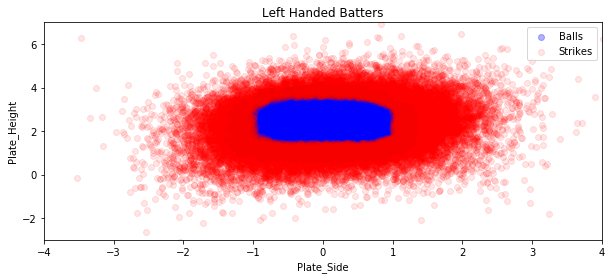

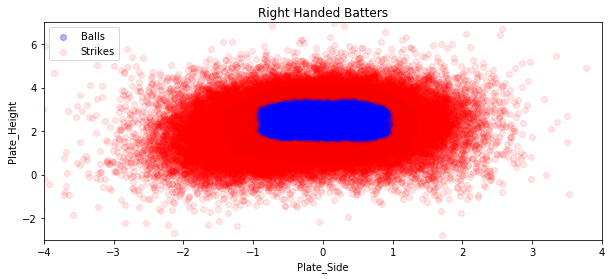

In [177]:
plt.figure(figsize=(10,4))


p1 =plt.scatter(dfnewlstrike['plate_side'], dfnewlstrike['plate_height'], color='b', alpha = .3)
p2 = plt.scatter(dfnewlball['plate_side'], dfnewlball['plate_height'], color='r', alpha = .1)

plt.xlabel('Plate_Side')
plt.ylabel('Plate_Height')
plt.xlim(-4,4)
plt.ylim(-3,7)
plt.legend((p1,p2),('Balls','Strikes'))
plt.title ('Left Handed Batters')
plt.show()
plt.figure(figsize=(10,4))

p3 = plt.scatter(dfnewrstrike['plate_side'], dfnewrstrike['plate_height'], color='b', alpha = .3)
p4 = plt.scatter(dfnewrball['plate_side'], dfnewrball['plate_height'], color='r', alpha = .1)

plt.xlabel('Plate_Side')
plt.xlim(-4,4)
plt.ylim(-3,7)
plt.ylabel('Plate_Height')
plt.title ('Right Handed Batters')
plt.legend((p3,p4),('Balls','Strikes'))
plt.show()